# Solving Simflied Thick Ptychography Model Least Squares Problem

This tutorial demonstrates how to use `thickptypy` to set up and solve a least_squares problem to reconstuct a thick sample.

The wave inversion is posed as a least-squares problem:

\begin{equation}
E(n) = \frac{1}{2} \sum_{i=1}^{N} \| p_i(n) - p_{\text{obs},i} \|^2_2,
\end{equation}

where $p_i$ and $p_{\text{obs},i}$ are the simulated and observed exit waves for the $i$-th probe position in Ptychography. 

$n(x,z)$ defines the refractive index of the volume

### 1. Import Libraries: Sample Space, Least Squares Solver and Visualisation

In [1]:
from thickptypy.sample_space.sample_space import SampleSpace
from thickptypy.reconstruction.least_squares import LeastSquaresSolver
from thickptypy.utils.visualisations import Visualisation

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "airy_disk"                 # Disk probe
wave_number = 0.5                   # Wavenumber (micrometers^-1)

# Continuous space limits (micrometers)
xlims = [0,300]                    # X limits in micrometers
zlims = [0,125]                   # Z limits in micrometers
continuous_dimensions = [
    xlims,
    zlims
    ]                     # Continuous dimensions in micrometers

# Discrete space parameters
propagation_slices = 100             # Number of z slices
probe_dimensions = [6]             # Discrete Probe dimensions
scan_points = 128                   # Large number of probes needed
step_size = 3                       # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"Pixels for compatibility with Diamond thin-sample simulation:")
print(f"nx = {min_nx}")
print(f"(These are also the minimum values for the discrete space limits)")

# Number of pixels in x directions
nx= 500
if nx < min_nx:
    nx = min_nx
discrete_dimensions = [
    nx,
    propagation_slices
    ]   

Pixels for compatibility with Diamond thin-sample simulation:
nx = 390
(These are also the minimum values for the discrete space limits)


### 3. Create Sample Space, Add Objects and Visualise it.

Add rectangles with specified refractive indices to the sample space.

In [3]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    wave_number,            # wavenumber in 1/nm
    n_medium=1.0,              # refractive index of the medium (default 1.0)
)
sample_space.summarize_sample_space()
visualisation = Visualisation(sample_space)

Summary of the scan (continuous):
    Sample space x: 300 um
    Sample space z: 125 um
    Probe Diameter: 3.61 um
    Number of scan points: 128
    Max Overlap: 1.81 um 



In [4]:
import numpy as np

np.random.seed(42)
delta = 0.005  # 1e-4
beta = 0.001   # 1e-6
# refractive_index1 = - np.random.uniform(delta*0.1, delta) - np.random.uniform(beta*0.1, beta)*1j
# refractive_index2 = - np.random.uniform(delta*0.1, delta) - np.random.uniform(beta*0.1, beta)*1j
# refractive_index3 = - np.random.uniform(delta*0.1, delta) - np.random.uniform(beta*0.1, beta)*1j
refractive_index = - delta - beta*1j
guassian_blur = 0.5

sample_space.add_object('circle', refractive_index, side_length=xlims[1]*0.03,
                        centre=(xlims[1]*0.6,zlims[1]*0.7),depth=zlims[1]*0.03,guassian_blur=guassian_blur)
sample_space.add_object('circle', refractive_index, side_length=xlims[1]*0.06,
                        centre=(xlims[1]*0.5,zlims[1]*0.5),depth=zlims[1]*0.06,guassian_blur=guassian_blur)
sample_space.add_object('circle', refractive_index, side_length=xlims[1]*0.1,
                        centre=(xlims[1]*0.35,zlims[1]*0.3),depth=zlims[1]*0.1,guassian_blur=guassian_blur)
# sample_space.add_object('circle', refractive_index2, side_length=xlims[1]*0.02,
#                         centre=(xlims[1]*0.6,zlims[1]*0.3),depth=zlims[1]*0.01,guassian_blur=guassian_blur)
# sample_space.add_object('circle', refractive_index2, side_length=xlims[1]*0.02,
#                         centre=(xlims[1]*0.3,zlims[1]*0.7),depth=zlims[1]*0.01,guassian_blur=guassian_blur)
sample_space.generate_sample_space()

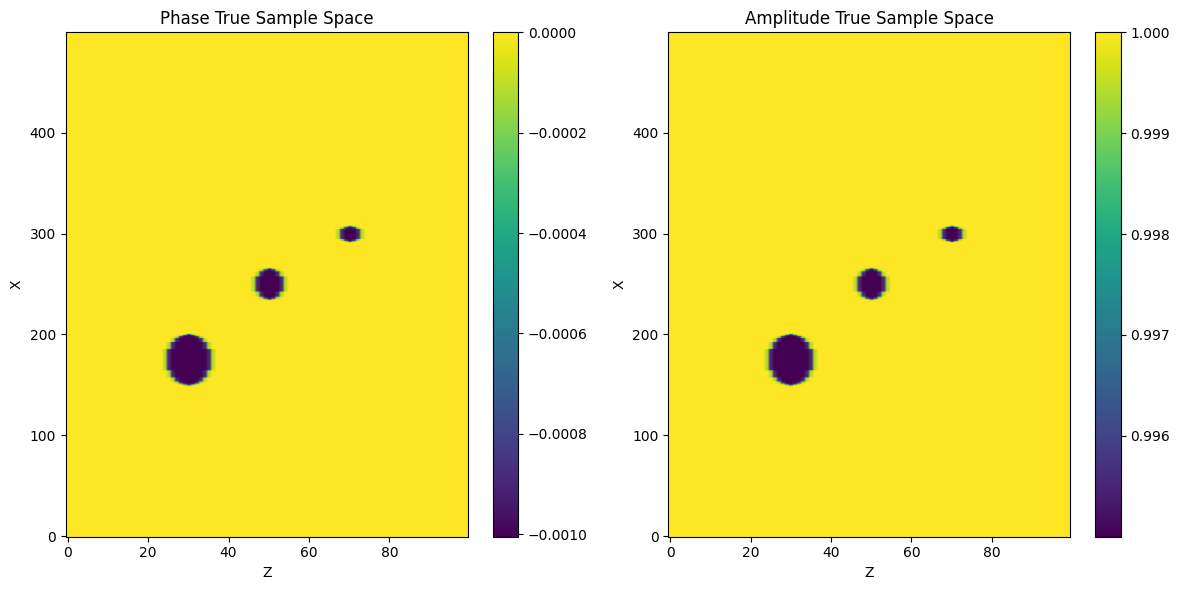

In [5]:
# Plot the true sample space
title = "True Sample Space"
visualisation.plot(sample_space.n_true, title=title)

### 6. Solve Least Squares to Reconstruct Simulated Sample Space


Initializing Least Squares Solver...
Solving the true forward problem once to generate the dataset...
True Forward Solution computed in 0.84 seconds.


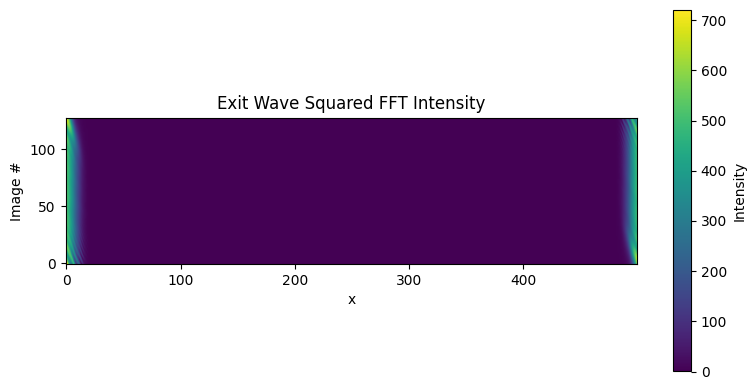

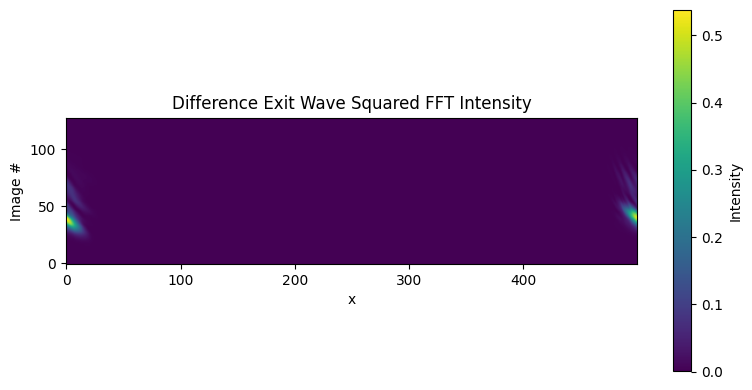

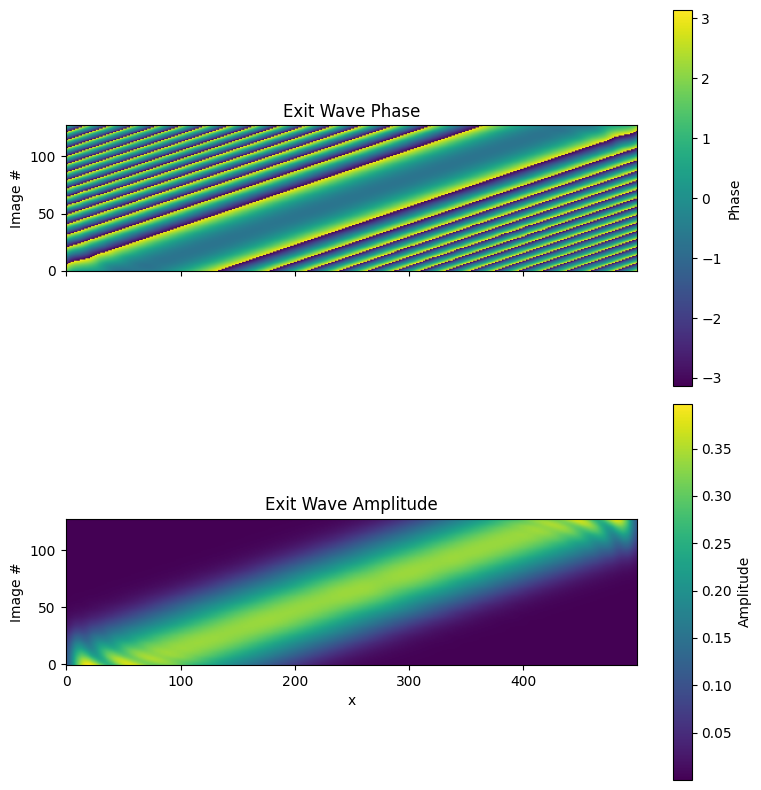

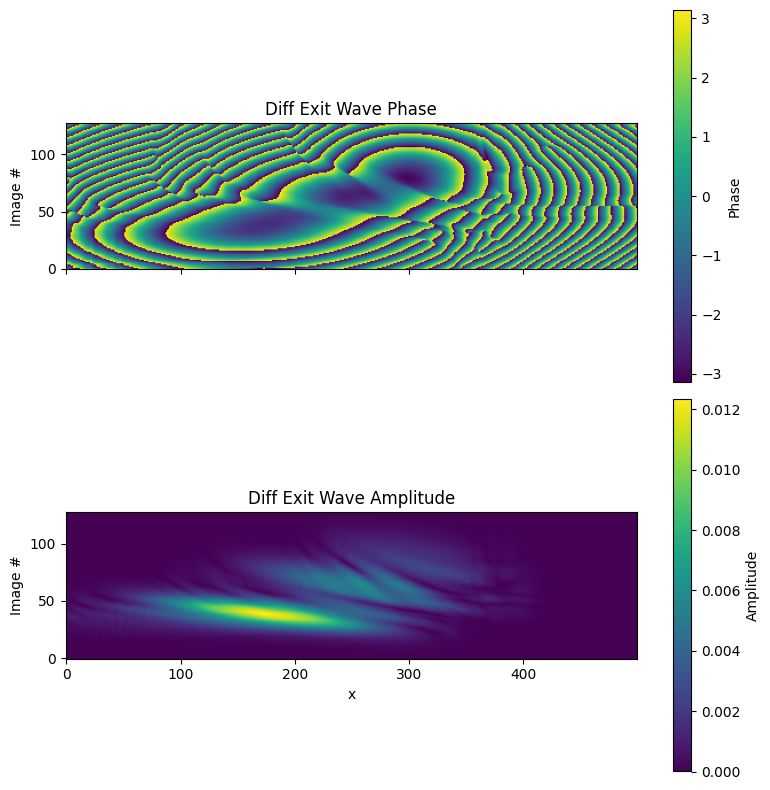

In [6]:
# Solve full system all-at-once or iteratively
least_squares = LeastSquaresSolver(sample_space,full_system_solver=False)

In [7]:
max_iters = 10
reconstructed_sample_space, reconstructed_wave, residual_history = (
    least_squares.solve(max_iters=max_iters,
                        plot_forward=False,
                        plot_reverse=False,
                        plot_object=False,
                        solve_probe=False,
                        sparsity_lambda=0.005)
)

# %load_ext line_profiler
# target_method = least_squares.solve
# %lprun -f target_method least_squares.solve(max_iters=max_iters,plot_forward=False, plot_reverse=False,plot_object=True,fixed_step_size=None,solve_probe=True,sparsity_lambda=0.0)#0.00002)


Iteration 1/10
    RMSE: 0.0005727902772544592
    Iteration 1 took 2.27 seconds.
Iteration 2/10
    RMSE: 0.0005703434295778081
    Iteration 2 took 2.48 seconds.
Iteration 3/10
    RMSE: 0.0005680658575639553
    Iteration 3 took 2.48 seconds.
Iteration 4/10
    RMSE: 0.0005658962112633578
    Iteration 4 took 2.47 seconds.
Iteration 5/10
    RMSE: 0.0005638283664906151
    Iteration 5 took 2.44 seconds.
Iteration 6/10
    RMSE: 0.0005618573443586407
    Iteration 6 took 2.43 seconds.
Iteration 7/10
    RMSE: 0.0005599789769127637
    Iteration 7 took 2.40 seconds.
Iteration 8/10
    RMSE: 0.0005581903026815958
    Iteration 8 took 2.43 seconds.
Iteration 9/10
    RMSE: 0.0005564903387020051
    Iteration 9 took 2.49 seconds.
Iteration 10/10
    RMSE: 0.0005548818637171859
    Iteration 10 took 2.64 seconds.


### 7. Visualise the Residual History and Final Iterations

Residual History of Least Squares Solve


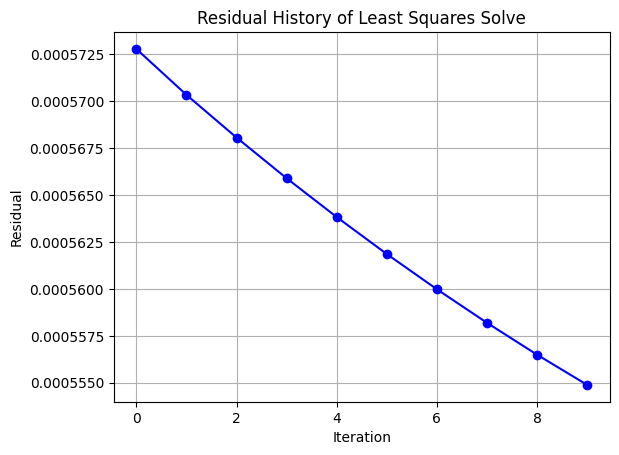

In [8]:
import matplotlib.pyplot as plt

# Log-log plot of residual
title ='Residual History of Least Squares Solve'
print(title)
plt.figure()
plt.plot(residual_history, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title(title)
plt.grid(True)
plt.show()

Reconstructed Sample Space


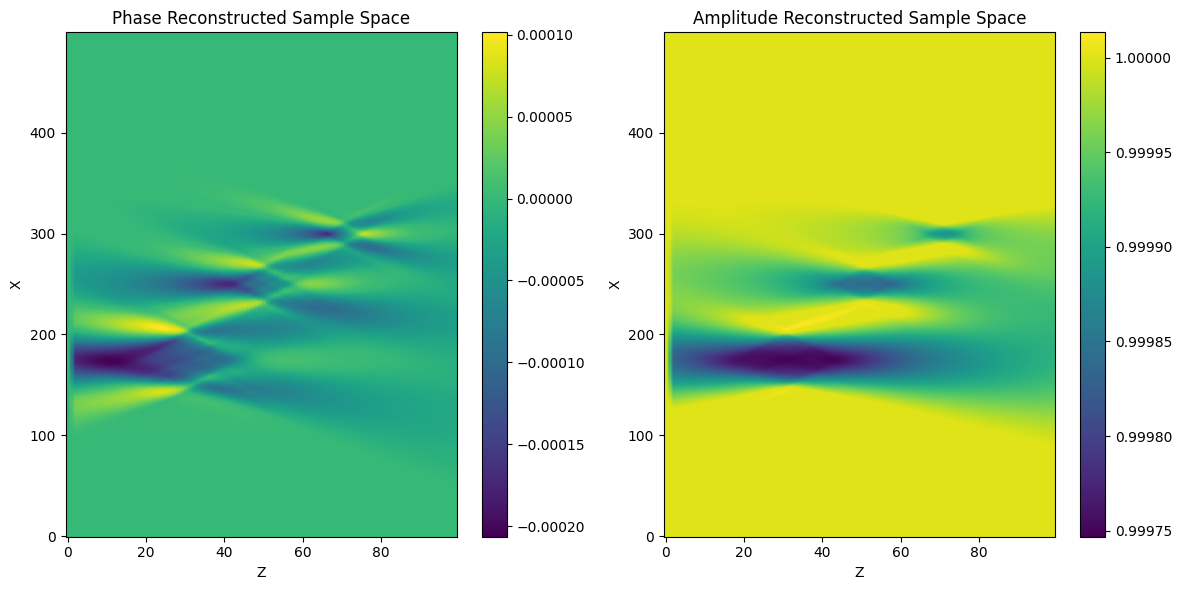

True Sample Space


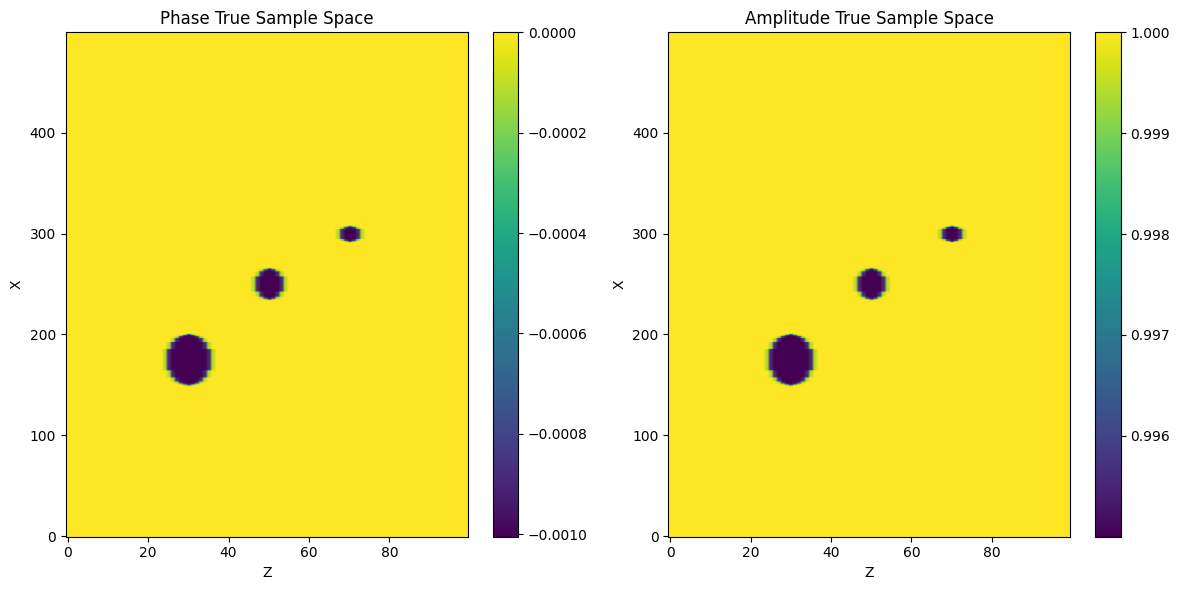

In [9]:
# Plot object field
title = "Reconstructed Sample Space"
print(title)
visualisation.plot(reconstructed_sample_space,title=title)

# Plot the true sample space
title = "True Sample Space"
print(title)
visualisation.plot(sample_space.n_true, title=title)

Reconstructed Wave


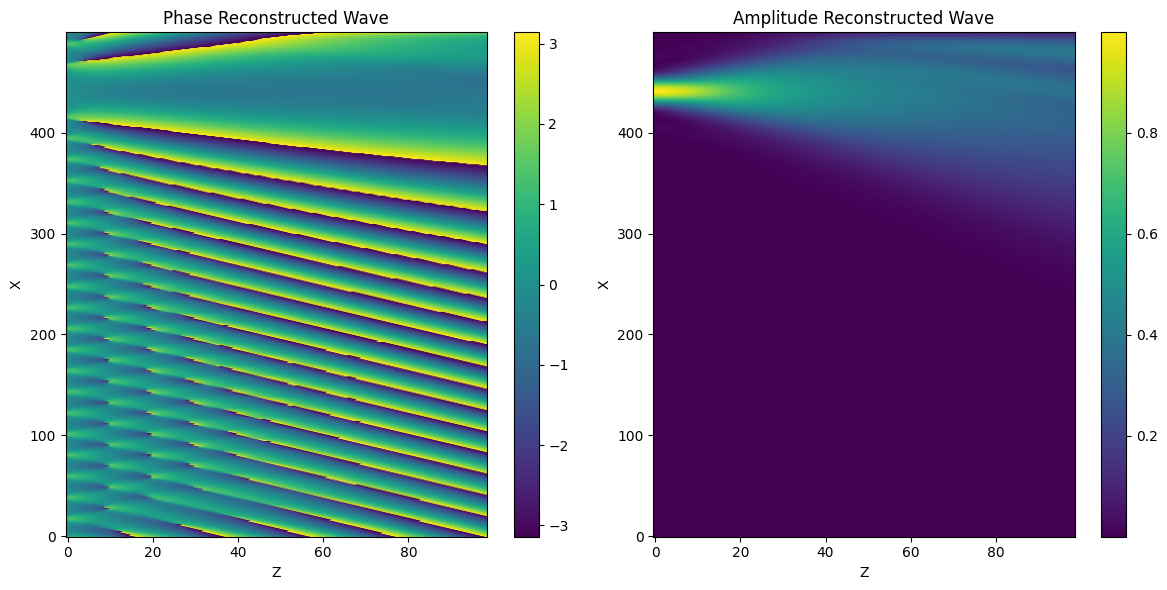

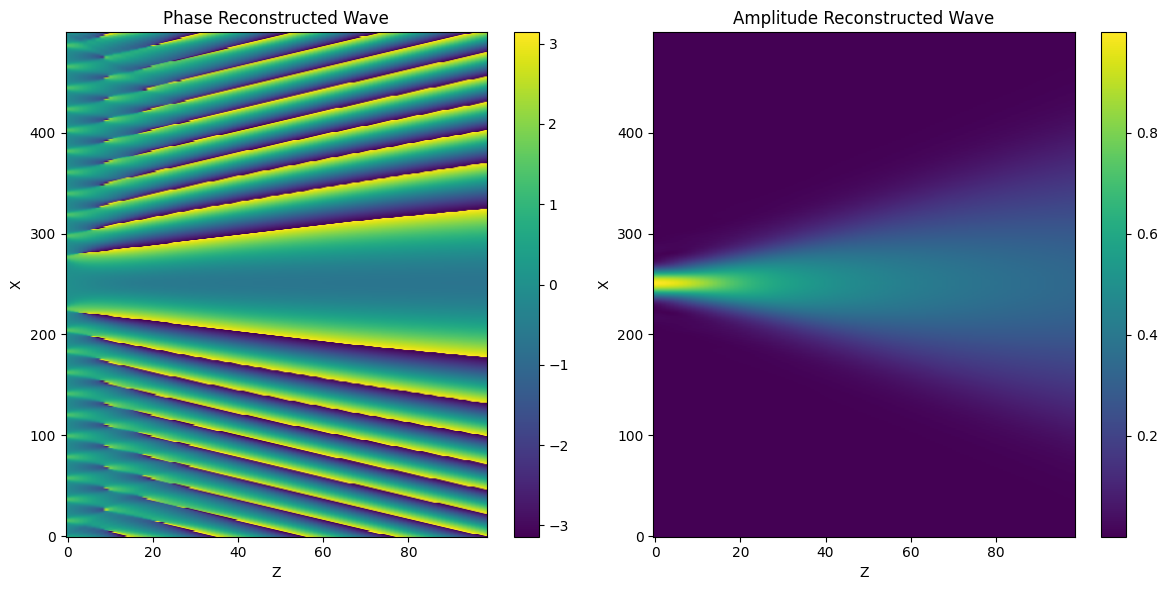

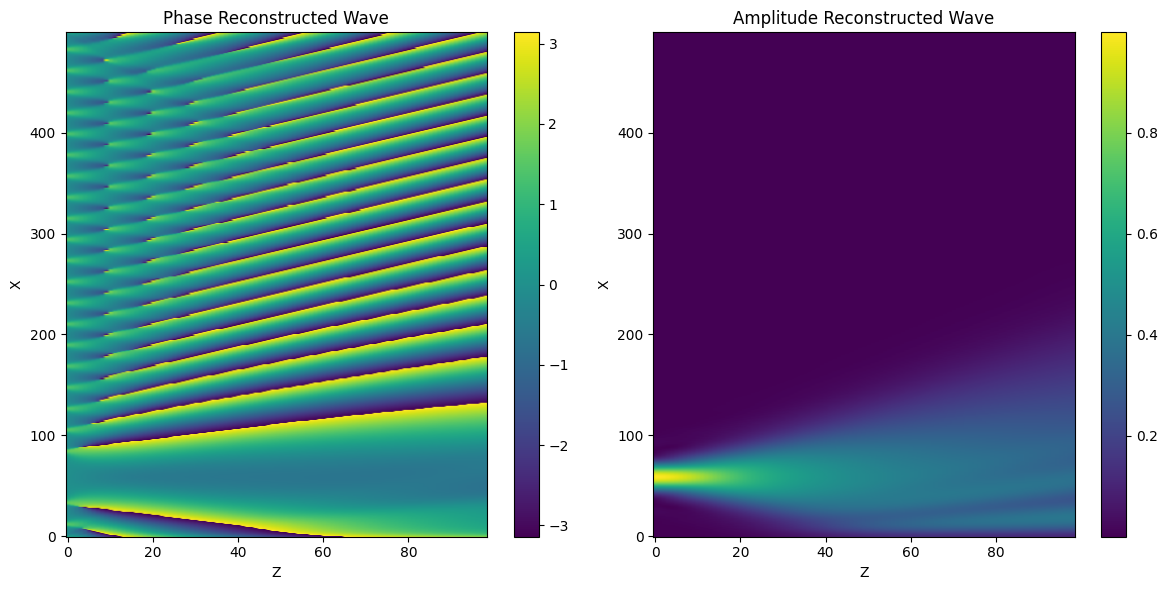

In [10]:
# Plot the reconstructed wave
title = "Reconstructed Wave"
print(title)
visualisation.plot(reconstructed_wave, title=title, probe_index=-1)
visualisation.plot(reconstructed_wave, title=title)
visualisation.plot(reconstructed_wave, title=title, probe_index=0)

In [11]:
# Profile the reconstruction
# %load_ext line_profiler
# %lprun -f SolveLeastSquares.compute_forward_model least_squares.solve(max_iters=max_iters, plot_forward=True, plot_object=True, fixed_step_size=False)
